# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Reading Data

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from time import time
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
portfolio.head(15)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape

(10, 6)

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
transcript.shape

(306534, 4)

# EDA (Exploratory Data Analysis)

In [8]:
# check Na and get the percentage 
profile.isna().sum()*100/profile.shape[0]

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

we have 12.8 % of missing value of age and income.

In [9]:
# check Na
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


we can see max of age is 118 !, that is maybe not correct. 

To make sure to get good insight we have to remove outlier form age and Na's in gender, but first remove Na's

In [11]:
profile = profile.dropna()

In [12]:
profile.shape

(14825, 5)

In [13]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [14]:
# convert to date type for became_member_on
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [15]:
profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


we can notice when Na's have been removed, max of age decreased until 101.

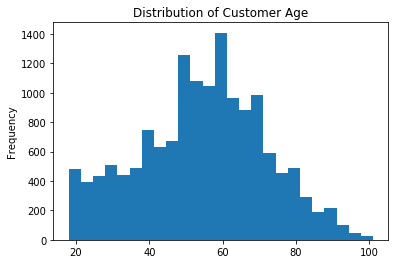

In [16]:
profile['age'].plot(kind='hist', bins=25, title='Distribution of Customer Age')

most of customer age is between 20 to 80

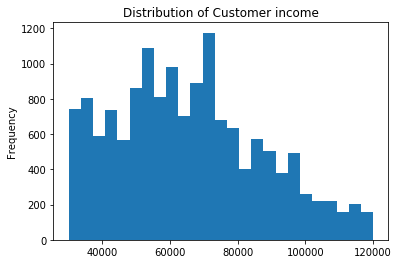

In [17]:
profile['income'].plot(kind='hist', bins=25, title='Distribution of Customer income')

most of customers income is less than 100,000 

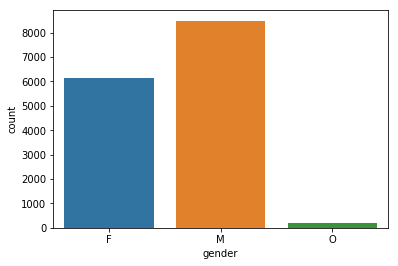

In [18]:
sns.countplot(profile['gender'])

Male are the highest customer.

In [20]:
#check number of unique people represented
transcript['person'].nunique()

17000

In [21]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


# Data Preparation

### portfolio cleaing:
1- one hot encode.
2- drop orginal columns.
3- Rename columns. 

In [22]:
def clean_portfolio(portfolio):
    
    # one-hot encode channels column
    channels = ['web', 'email', 'mobile', 'social']

    for channel in channels:
        portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
        
    # one-hot encode offer_type
    #dummies = pd.get_dummies(portfolio['offer_type'], prefix='event_type', prefix_sep='_')

    # Concatenate with the original dataframe
    #portfolio = pd.concat([portfolio, dummies], axis=1)
    
    # Drop original columns
    portfolio.drop(['channels'] ,axis=1 ,inplace=True) #, 'offer_type']
    
    # rename column 
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    portfolio.rename(columns={'duration': 'offer_duration_days'}, inplace=True)
    portfolio.rename(columns={'difficulty': 'offer_difficulty'}, inplace=True)
    portfolio.rename(columns={'reward': 'offer_reward'}, inplace=True)
    for col in ["email", "mobile", "social", "web"]:
        portfolio.rename(columns={col: ("channel_" + col)}, inplace=True)

    
    return portfolio

In [23]:
clean_portfolio = clean_portfolio(portfolio)

In [24]:
clean_portfolio.head(15)

,offer_difficulty,offer_duration_days,offer_id,offer_type,offer_reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


### profile cleaning:
1- One-hot encode  for gender.
2- drop orginal gender.

In [25]:
def clean_profile(profile):

    # One-hot encode gender
    #gender_dummies = pd.get_dummies(profile.gender, prefix='gender', prefix_sep='_')
    #profile = pd.concat([profile, gender_dummies], axis=1)
    
    
    # Drop original column
    #profile.drop(['gender'], axis=1, inplace=True)
    
    # rename column 
    #profile.rename(columns={'id': 'customer_id'}, inplace=True)

    
    return profile

In [26]:
clean_profile = clean_profile(profile)

In [27]:
clean_profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


### transcript cleaning:
1- clean value column.
2- drop unwanted column.
3- create dummies variable.


In [28]:
# Transcript cleaning function 
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''

    # create new dataframes from filters 
    trans = transcript[transcript.event == 'transaction']
    received = transcript[transcript.event == 'offer received']
    viewed = transcript[transcript.event == 'offer viewed']
    completed = transcript[transcript.event == 'offer completed']
    trans['amount'] = trans.value.apply(lambda x:list(x.values())[0])
    received['offer_id'] = received.value.apply(lambda x:list(x.values())[0])
    viewed['offer_id'] = viewed.value.apply(lambda x:list(x.values())[0])
    completed['offer_id'] = completed.value.apply(lambda x:list(x.values())[0])
    completed['reward'] = completed.value.apply(lambda x:list(x.values())[1])
    # concat the new dataframes into one dataset transcript
    transcript = pd.concat([trans,received,viewed,completed])
    # select and drop necessary columns 
    transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
    transcript.drop(columns='value' , inplace=True)

    return transcript

In [29]:
clean_transcript = clean_transcript(transcript)

In [30]:
clean_transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


In [31]:
# create dummies 
clean_transcript = pd.get_dummies(clean_transcript , columns=['event'] , prefix='' ,prefix_sep='')

In [32]:
clean_transcript.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN,0,0,0,1


In [33]:
# check duplicte
clean_transcript.duplicated().sum()

397

In [34]:
# Remove duplicated
clean_transcript.drop_duplicates(inplace=True)

## Data Merge

### first: clean_transcript and clean_profile

In [35]:
merged_data = pd.merge(clean_transcript , clean_profile ,left_on='person' , right_on='id',how='inner')
merged_data.drop(columns=['id'] , inplace=True)

In [36]:
# check duplicte
merged_data.duplicated().sum()

0

In [37]:
# check na
merged_data.isna().sum()

person                   0
offer_id            123957
time                     0
amount              148431
reward              240318
offer completed          0
offer received           0
offer viewed             0
transaction              0
age                      0
became_member_on         0
gender                   0
income                   0
dtype: int64

In [38]:
merged_data.shape

(272388, 13)

In [39]:
# remove na
merged_data.dropna(subset=['offer_id'] ,inplace=True)

In [40]:
merged_data.shape

(148431, 13)

In [41]:
merged_data.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income
10,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,NaN,NaN,0,1,0,0,20,2016-07-11,F,30000.0
11,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,NaN,NaN,0,1,0,0,20,2016-07-11,F,30000.0
12,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,NaN,NaN,0,0,1,0,20,2016-07-11,F,30000.0
25,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,NaN,NaN,0,1,0,0,42,2016-01-17,M,96000.0
26,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,336,NaN,NaN,0,1,0,0,42,2016-01-17,M,96000.0


### Second: merged_data and clean_portfolio

In [42]:
merged_data1 = merged_data.merge(clean_portfolio , left_on='offer_id' , right_on='offer_id'  ,how='left')
merged_data1.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,...,gender,income,offer_difficulty,offer_duration_days,offer_type,offer_reward,channel_web,channel_email,channel_mobile,channel_social
0,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,NaN,NaN,0,1,0,0,20,...,F,30000.0,10,7,bogo,10,0,1,1,1
1,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,NaN,NaN,0,1,0,0,20,...,F,30000.0,20,10,discount,5,1,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,NaN,NaN,0,0,1,0,20,...,F,30000.0,10,7,bogo,10,0,1,1,1
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,NaN,NaN,0,1,0,0,42,...,M,96000.0,10,7,discount,2,1,1,1,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,336,NaN,NaN,0,1,0,0,42,...,M,96000.0,7,7,discount,3,1,1,1,1


In [43]:
merged_data1.columns

Index(['person', 'offer_id', 'time', 'amount', 'reward', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'age',
       'became_member_on', 'gender', 'income', 'offer_difficulty',
       'offer_duration_days', 'offer_type', 'offer_reward', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social'],
      dtype='object')

In [44]:
Model_data = merged_data1.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()
Model_data.head()

,person,offer_type,offer completed,offer received,offer viewed,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,33,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,33,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,informational,0,2,2,33,2017-04-21,M,72000.0
3,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,1,40,2018-01-09,O,57000.0
4,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,2,40,2018-01-09,O,57000.0


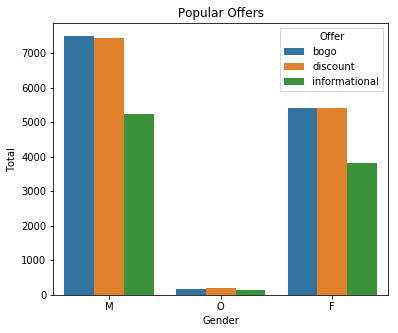

In [69]:
plt.figure(figsize=(6, 5))
sns.countplot(x=Model_data.gender, hue=Model_data.offer_type)
plt.title('Popular Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

In [45]:
def offers_transformation(df):
    '''
    Function: to transform the offers
    
    Returns: The transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0
    # Transform BOGO offer 
    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']
    # Transform dsicount offer
        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
    # groupby by person    
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [46]:
data = offers_transformation(Model_data)

In [47]:
data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3


In [48]:
# create colunms with the precnetage of each offer
data['bogo_perce'] = data.bogo_completed.div(data.bogo_received.where(data.bogo_received != 0, np.nan))*100
data['discount_perce'] = data.discount_completed.div(data.discount_received.where(data.discount_received != 0, np.nan))*100

In [49]:
data.isna().sum()

person                   0
age                      0
became_member_on         0
gender                   0
income                   0
bogo_received            0
bogo_completed           0
discount_received        0
discount_completed       0
bogo_perce            1738
discount_perce        1778
dtype: int64

In [50]:
data.fillna(0 , inplace=True)

In [51]:
data['bogo_offer'] = 0
data['discount_offer'] = 0


for i ,row in data.iterrows():

    if(row['bogo_perce'] >= 80):
        data.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_perce'] >= 80 ):
        data.loc[i , 'discount_offer'] = 1

In [52]:
data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_perce,discount_perce,bogo_offer,discount_offer
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2,100.0,100.0,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2,100.0,100.0,1,1
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2,50.0,100.0,0,1
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1,100.0,100.0,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3,0.0,100.0,0,1


# Data Modeling 

After data preparation, our model will predic if offer will respond by the customer or not.
if customer respond then model will choose discount or BOGO .

In [53]:
model_data2 = data.copy()
# create year and month columns from became_member_on column
model_data2['year'] = model_data2.became_member_on.dt.year
model_data2['month'] = model_data2.became_member_on.dt.month

In [54]:
# features that we need 
model_data2 = model_data2[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]
model_data2.head()

,age,gender,income,year,month,discount_offer,bogo_offer
0,33,M,72000.0,2017,4,1,1
1,40,O,57000.0,2018,1,1,1
2,59,F,90000.0,2016,3,1,0
3,24,F,60000.0,2016,11,1,1
4,26,F,73000.0,2017,6,1,0


In [55]:
# create dummy for column 'gender'
model_data3 = pd.get_dummies(model_data2 , columns=['gender'])

In [56]:
# now choose features and target 
X = model_data3.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = model_data3.bogo_offer
y_discount = model_data3.discount_offer

In [57]:
model_data3.head()

,age,income,year,month,discount_offer,bogo_offer,gender_F,gender_M,gender_O
0,33,72000.0,2017,4,1,1,0,1,0
1,40,57000.0,2018,1,1,1,0,0,1
2,59,90000.0,2016,3,1,0,1,0,0
3,24,60000.0,2016,11,1,1,1,0,0
4,26,73000.0,2017,6,1,0,1,0,0


split data set into train and test 

In [58]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

### now, we will choose three different algorithms to build our model.

### 1. Logistic Regression

In [59]:
bogo_LR = LogisticRegression()
discount_LR = LogisticRegression()
bogo_LR.fit(X_train, y_bogo_train)
discount_LR.fit(X_train, y_discount_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
print('Bogo offer Train F1_score {}'.format( bogo_LR.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(bogo_LR.score(X_test,y_discount_test)))
print('Discount offer Train F1_score {}'.format(discount_LR.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_LR.score(X_test,y_discount_test)))

Bogo offer Train F1_score 0.5741790373369321
Bogo offer Test F1_score 0.5676113360323887
Discount offer Train F1_score 0.5901934322986955
Discount offer Test F1_score 0.5870445344129555


### 2. Decision Tree Classifier

In [61]:
bogo_DT = DecisionTreeClassifier()
discount_DT = DecisionTreeClassifier()
bogo_DT.fit(X_train, y_bogo_train)
discount_DT.fit(X_train, y_discount_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [66]:
print('Bogo offer Train F1_score {}'.format( bogo_DT.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(bogo_DT.score(X_test,y_discount_test)))
print('Discount offer Train F1_score {}'.format(discount_DT.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_DT.score(X_test,y_discount_test)))

Bogo offer Train F1_score 0.6656770130454341
Bogo offer Test F1_score 0.5813765182186235
Discount offer Train F1_score 0.9919028340080972
Discount offer Test F1_score 0.5732793522267207


### 3. Random Forest Classifier 

In [63]:
bogo_RF = RandomForestRegressor(n_estimators=10,min_samples_leaf=20)
discount_RF = RandomForestRegressor(n_estimators=10,min_samples_leaf=20)
bogo_RF.fit(X_train, y_bogo_train)
discount_RF.fit(X_train, y_discount_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [67]:
print('Bogo offer Train F1_score {}'.format( bogo_RF.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(bogo_RF.score(X_test,y_discount_test)))
print('Discount offer Train F1_score {}'.format(discount_RF.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(discount_RF.score(X_test,y_discount_test)))

Bogo offer Train F1_score 0.11018878047090586
Bogo offer Test F1_score 0.10240351660040992
Discount offer Train F1_score 0.2234564331221094
Discount offer Test F1_score 0.10874632013801411


# Result of Models and Decision 

1. the highest accuracy in Bogo offer training is for Decision Tree with 66.56% 

2. the highest accuracy in Bogo offer testing is for Decision Tree with 58.13%

3. the highest accuracy in Discount offer training is for Decision Tree with 99.19%

4. the highest accuracy in Discount offer training is for Logistic Regression with 58.70% 

5. the lowest accuracy for dogo and discount are for Random Forest between 22% to 10% !. which not a good indicator. 

6. Most of customer are Male, they prefer   bogo and discount offers, also to female, but they less than male.

We built thies models to predict whether a customer will respond to an offer BOGO or discount. 
We worked with three datasets for starbucks, starting with reading data and data wrangling, then merge all datasets to preparet for models, after that we calculated accuracy for each model and got the result above.